In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import imageio
import random
import time
from itertools import permutations
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from sklearn.cluster import AgglomerativeClustering
from IPython.display import clear_output
import seaborn as sns; sns.set()
from scipy.stats import entropy
#from sklearn import metrics
#from sklearn.datasets.samples_generator import make_blobs
#from sklearn.preprocessing import StandardScaler
#from skimage import img_as_ubyte
from faker import Faker

In [2]:
def sig_func(x,y):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        y: The second parameter.

    Returns:
        The return value.
        
    """
    
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def mutate(x,rate):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        rate: The second parameter.

    Returns:
        The return value.
        
    """
    
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = 2*np.random.random(1)-1
    return(x)

In [4]:
def intersection(lst1, lst2):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    return list(set(lst1) & set(lst2))

In [5]:
def extract_tribe(cells, cell_weights, n, labels, node_n = 225):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    db = AgglomerativeClustering(n).fit(cell_weights)
    print(db.labels_)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    flags = flags[1:]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    return(next_cells[0], next_weights[0], db)

In [6]:
def fuzzy_logic(a):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    less_norm = np.linalg.norm([i for i in a if i <= np.median(a)])
    cutoff = np.min(a)/less_norm + np.random.rand()*((np.median(a)-np.min(a))/less_norm)
    choice = a.index(np.random.choice([i for i in a if i <= cutoff*less_norm]))
    
    return(choice)

In [7]:
def slime(x = [],
          y = [],
          start_pop = 200,
          max_age = 100,
          fig_size = [5,5],
          board_size = 128,
          fertile = 6,
          start_hp = 4,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 40,
          willing_wait = 5,
          experimental = False,
          mode='once'):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.

    """
    
    global sight
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global cell_name
    global killed
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    global max_hp
    global frame_count
    global fake
    global fake_names
    
    fake = Faker()    
    total_start_time = time.time()
    frame_count = 1
    max_hp = fertile
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    cell_name = 1
    fake_names = fake.name()
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Build the initial cell list.  Skip this if one from a previous run is submitted.
    # The NN is built around sight/input of 9*9, movement/output of 3*3.
    if(len(x) < 1):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        
        for cell in range(0,start_pop):
            cells[cell,:] = [cell_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          start_hp,
                          1]
            cell_weights[cell,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(cell)
            cell_name += 1
            fake_names = np.append(fake_names,fake.name())
            
    else:
        cells = x
        cell_weights = y

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(10*X)
        return(im,)
    
    # Get the relative coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    keep = [0,0]
    
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='magma', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global cell_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        global max_hp
        global frame_count
        global fake
        global fake_names
        
        """Example function with PEP 484 type annotations.

        Args:
            lst1: The first parameter.
            lst2: The second parameter.

        Returns:
            The return value.

        """
        
        # Warning for long frame generation wait time.
        if(last_time > willing_wait):
            print("Taking too long...  Frame {} took {} seconds.".format((frame_count-1),round(last_time,1)))
        
        # Initial values.
        start_time = time.time()
        grow_count = 0
        birth_count = 0
        bump_count = 0
        killed_this_round = np.array([], dtype = int)
        
        # Take turns through the cell list for each frame.
        time_tick += 1
        im.set_data(10*animate.X)
        
        try:
            p = (np.transpose(PCA(n_components=3).fit(np.transpose(cell_weights)).components_)+1)/2
            rgb = np.round(255*(p-np.min(p))/(np.max(p)-np.min(p)))/((256^2)*256 + 256*256 + 256)
            cell_color = (256^2)*rgb[:,0] + 256*rgb[:,1] + rgb[:,2]
            
        except:
            print("Extinction event occured!  Had to return.")
            return(im,)
        
        cell_count = len(cells)
        
        for cell in range(0, cell_count):
            if(int(cell in killed_this_round) == 0):
                # Input.
                test_in = []
                for perm in np.mod(cells[cell,1:3] + np.unique(keep,axis=0), board_size):
                    test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])

                # Output.
                test_out = sig_func(test_in,cell_weights[cell,:].reshape((sight*sight, 3*3)))
                d = fuzzy_logic(test_out.tolist())

                # Rest and recover up to half fertile health.
                if(d==4):
                    if(cells[cell,3] < max_hp/2):
                        cells[cell,3] += 1
                        grow_count += 1
                        if(log == True):
                            print("{} raised hp to {}.".format(fake_names[cell], cells[cell,3]))

                    # Handle birth/splitting, don't clear.
                    if(cells[cell,3] >= max_hp):

                        # Get the relative coodinates for possible baby locations.
                        L = [0, 0, 1, 1, -1, -1]
                        keep2 = [0,0]

                        for comb in permutations(L, r=2):
                            keep2 = np.vstack((keep2, comb))

                        potential = []
                        for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                            potential = np.append(potential, X[int(perm[0]), int(perm[1])])

                        # Check if location for baby is clear
                        clear = []
                        for i in potential:
                            if(i == 0):
                                clear = np.append(clear,i)

                        # Cell division process, only divide if there is a vacant destination to choose from.
                        if(len(clear) > 0):
                            d = np.random.choice(range(0,len(clear)))
                            # Give new coordinate and fill it in.
                            destination = np.mod(np.add(cells[int(cell),1:3], new_coord[d]), board_size)

                            # Half parent hp.
                            divided_hp = np.floor(cells[cell,3]/2)
                            cells[cell,3] = divided_hp

                            # Give the baby attributes.
                            baby_name = cell_name
                            G.add_node(baby_name)
                            G.add_edge(cell_name, baby_name)
                            cell_name += 1
                            fake_baby_name = fake.name()
                            fake_names = np.append(fake_names,fake_baby_name)

                            a = [baby_name,
                                 int(destination[0]),
                                 int(destination[1]),
                                 divided_hp,
                                 1]

                            # Mutate the baby's NN
                            b = mutate(cell_weights[cell,:], mutation_rate)
                            cells = np.vstack((cells, a)) 
                            cell_weights = np.vstack((cell_weights, b))
                            #X[int(destination[0]), int(destination[1])] = abs(sum(b))
                            p = (np.transpose(PCA(n_components=3).fit(np.transpose(cell_weights)).components_)+1)/2
                            rgb = np.round(255*(p-np.min(p))/(np.max(p)-np.min(p)))/((256^2)*256 + 256*256 + 256)
                            X[int(destination[0]), int(destination[1])] = (256^2)*rgb[cell,0] + 256*rgb[cell,1] + rgb[cell,2]

                            birth_count += 1
                            if(log == True):
                                print("{} underwent mitosis.  Gave birth to {}.".format(fake_names[cell], fake_baby_name))

                # Movement logic.
                else:
                    # If it is clear to move.
                    destination = np.mod(np.add(cells[cell,1:3], new_coord[d]), board_size)

                    if(X[int(destination[0]), int(destination[1])] == 0):
                        # Clear where it was since it is not splitting.
                        last_spot = cells[cell,1:3]
                        X[int(last_spot[0]),int(last_spot[1])] = 0         
                        # Give new coordinate and fill it in.
                        cells[cell,1:3] = destination
                        #X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[cell,:]))
                        X[int(destination[0]), int(destination[1])] = cell_color[cell]

                    else:
                        # It has an altercation    
                        x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                        y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                        z = intersection(x,y)

                        # Make sure there is no ambiguity
                        if(len(z) == 1):
                            z = z[0]
                            # The outcome is determined by hit points, age and who is initiating.
                            # The following ratio incorperates ages of predator and prey
                            rat = np.log(cells[z,4]/cells[cell,4])/np.e

                            # Experimental ################################################
                            if(experimental == True):
                                # Get the relative coodinates
                                L = [0, 0, 1, 1, -1, -1]
                                keep2 = [0,0]
                                for comb in permutations(L, r=2):
                                    keep2 = np.vstack((keep2, comb))
                                potential = []
                                for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                                    potential = np.append(potential, X[int(perm[0]), int(perm[1])])
                            ###############################################################

                            if(cells[cell,3] > cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] += np.round(3+rat)
                                cells[z,3] -= np.round(3+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))


                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))     
                                ###############################################################

                            if(cells[cell,3] == cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] += np.round(1+rat)
                                cells[z,3] -= np.round(1+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))
                                ###############################################################

                            if(cells[cell,3] < cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] -= np.round(2-rat)
                                cells[z,3] += np.round(2-rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(0,9)))
                                    reward[d] = 1
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward)) 
                                ###############################################################

                            # Experimental ################################################
                            if(log == True):
                                print("Experimental nurture reenforcement modified {}'s neural network.".format(fake_names[cell]))  
                            ###############################################################

                            bump_count += 1

                            try:
                                # Handle cell death.
                                if(cells[cell,3] < 1):
                                    # Clear where the attacker was and add to the death list.
                                    last_spot = cells[cell,1:3]
                                    X[int(last_spot[0]),int(last_spot[1])] = 0
                                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                                    if(log == True):
                                        print("{} collapsed dead from injury!.".format(fake_names[cell]))

                                if(cells[z,3] < 1):
                                    # Clear where the victim was and add to the death list.
                                    last_spot = cells[z,1:3]
                                    X[int(last_spot[0]),int(last_spot[1])] = 0
                                    killed_this_round = np.append(killed_this_round,int(cells[z,0]))
                                    if(log == True):
                                        print("{} collapsed dead from injury!.".format(fake_names[z]))
                            except:
                                pass

        # Kill the elderly        
        for cell in range(0, cell_count):
            if(cells[cell,4] > max_age):
                # Blur max age a bit.
                if(np.random.random() < (cells[cell,4]-max_age)/max_age):      
                    # Add to the death list.
                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                    if(log == True):
                        print("{} died of old age!.".format(fake_names[cell]))

        # Finally handle the death list and delete cells
        for i in np.unique(killed_this_round):
            try:
                j = list(cells[:,0]).index((i))
                last_spot = cells[j,1:3]
                X[int(last_spot[0]),int(last_spot[1])] = 0
                cells = np.delete(cells, (j), axis=0)
                cell_weights = np.delete(cell_weights, (j), axis=0)
                fake_names = np.delete(fake_names, (j))
                if(log == True):
                    print("{} died at age {}.".format(fake_names[j],cells[j,4]))

            except:
                pass

        # Dynamic population control
        if(np.random.random() < -np.log(cell_count/(start_pop)/np.e)):
            if(max_hp > 3):
                    max_hp -= 1
                    print("We're going extinct, make babies!  Breeding requirements decreased to {}.".format(max_hp))

        if(np.random.random() < np.log(cell_count/(start_pop)/np.e)):
                max_hp += 1
                print("Too crowded, stop having kids!  Breeding requirements increased to {}.".format(max_hp))

        mean_var = np.mean(np.var(cell_weights,axis = 0))
        cell_count = len(cells)

        # Tick everyone's age
        cells[:,4] = np.add(cells[:,4],1)
        # Capture array for gif
        for_gif = np.concatenate((for_gif, X))
        # Capture death statistics
        death_count = len(np.unique(killed_this_round))
        # Current frame summary
        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count, cell_count, mean_var])
        # Append to run summary
        trends = np.vstack((trends, current))
        # Get the current frame run time to check next frame
        last_time = time.time() - start_time
        # Log every 10 frames to monitor full run time and check frame generation time.
        if(np.mod(frame_count,10) == 0):
            #clear_output(wait=True)
            print("Frame {} took {} seconds.".format(frame_count,round(last_time,1)))
        frame_count += 1
    
        return(im,)
    
    # Handles the browser animation viewer.
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make a little animated gif
    images = []
    for i in range(0,(frames+1)):
        converted = np.reshape(for_gif,(len(trends),board_size,board_size))[int(i),:,:]
        imageio.imwrite('slime.gif', converted)
        #clear_output(wait=True)
        images.append(imageio.imread('slime.gif'))
    imageio.mimsave('slime.gif', images)
    
    # Total run time
    total_last_time = time.time() - total_start_time
    #clear_output(wait=True)
    print("Total Run Time:  {} seconds.".format(round(total_last_time,1)))
    
    return(html_result, cells, cell_weights, G, trends[1:,:], for_gif)

In [8]:
gr, c, cw, g, t, a = slime(start_pop=100, board_size=128, frames=100, experimental = True, log = True)

Ronald Collins attacked Daniel Ellis!
Ronald Collins hp: 4.0 --> 5.0
Daniel Ellis hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Ronald Collins's neural network.
Christopher Garcia attacked Dr. Lisa Wilkinson!
Christopher Garcia hp: 4.0 --> 5.0
Dr. Lisa Wilkinson hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Christopher Garcia's neural network.
Keith Davis attacked Daniel Ellis!
Keith Davis hp: 4.0 --> 7.0
Daniel Ellis hp: 3.0 --> 0.0
Experimental nurture reenforcement modified Keith Davis's neural network.
Daniel Ellis collapsed dead from injury!.
Megan Gates died at age 1.0.
We're going extinct, make babies!  Breeding requirements decreased to 5.
Samuel Rogers attacked Victor Shaffer!
Samuel Rogers hp: 4.0 --> 5.0
Victor Shaffer hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Samuel Rogers's neural network.
John Aguirre attacked Sarah Middleton!
John Aguirre hp: 4.0 --> 5.0
Sarah Middleton hp: 4.0 --> 3.0
Experimental nurture reenforcement modif

Samuel Rogers died at age 5.0.
Alexandra Robbins died at age 5.0.
Keith Davis died at age 5.0.
Christina Higgins died at age 5.0.
Ashley Williams died at age 3.0.
Dr. Lisa Wilkinson underwent mitosis.  Gave birth to Sean Young.
Gabrielle Woodard attacked Samuel Rogers!
Gabrielle Woodard hp: 4.0 --> 2.0
Samuel Rogers hp: 12.0 --> 14.0
Experimental nurture reenforcement modified Gabrielle Woodard's neural network.
Christopher King underwent mitosis.  Gave birth to Jordan Hamilton.
Kelly Miller attacked Patrick Smith!
Kelly Miller hp: 2.0 --> 0.0
Patrick Smith hp: 4.0 --> 6.0
Experimental nurture reenforcement modified Kelly Miller's neural network.
Kelly Miller collapsed dead from injury!.
Amanda Ramos attacked Jenna Freeman!
Amanda Ramos hp: 3.0 --> 6.0
Jenna Freeman hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Amanda Ramos's neural network.
Jenna Freeman collapsed dead from injury!.
Angelica Barnes underwent mitosis.  Gave birth to Kathy Lewis.
Drew Ramirez attacked Vic

Matthew Holmes attacked Tyler Carter!
Matthew Holmes hp: 2.0 --> 2.0
Tyler Carter hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Matthew Holmes's neural network.
Robert Ramirez attacked Michelle Johnson!
Robert Ramirez hp: 12.0 --> 15.0
Michelle Johnson hp: 4.0 --> 1.0
Experimental nurture reenforcement modified Robert Ramirez's neural network.
Lori Hawkins underwent mitosis.  Gave birth to Evan Hutchinson.
Christopher Larsen underwent mitosis.  Gave birth to Michele Davidson.
Mandy Diaz underwent mitosis.  Gave birth to William Moon.
William Friedman underwent mitosis.  Gave birth to Elizabeth Hernandez.
Michael Benson raised hp to 2.0.
Samuel Rogers died at age 9.0.
Katherine Morgan died at age 3.0.
Heather Noble attacked Jennifer Ellison!
Heather Noble hp: 11.0 --> 14.0
Jennifer Ellison hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Heather Noble's neural network.
Jennifer Ellison collapsed dead from injury!.
April Chan attacked Margaret Freeman!
April Cha

Emma Sanchez attacked Adrian Wolf!
Emma Sanchez hp: 3.0 --> 6.0
Adrian Wolf hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Emma Sanchez's neural network.
Adrian Wolf collapsed dead from injury!.
Rebecca Martinez underwent mitosis.  Gave birth to Jamie Mullen.
Christopher King underwent mitosis.  Gave birth to Tracy Mcconnell.
William Ewing attacked Kyle Williams III!
William Ewing hp: 4.0 --> 7.0
Kyle Williams III hp: 3.0 --> 0.0
Experimental nurture reenforcement modified William Ewing's neural network.
Kyle Williams III collapsed dead from injury!.
Dr. Shannon Conner attacked Meagan Green!
Dr. Shannon Conner hp: 1.0 --> -1.0
Meagan Green hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Dr. Shannon Conner's neural network.
Dr. Shannon Conner collapsed dead from injury!.
Mark Powell attacked Tyler Edwards!
Mark Powell hp: 2.0 --> 3.0
Tyler Edwards hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Mark Powell's neural network.
Robert Ramirez underwent 

Ashley Saunders underwent mitosis.  Gave birth to Richard Cole.
David Davis underwent mitosis.  Gave birth to Natalie Gonzales.
Bryan Reyes underwent mitosis.  Gave birth to Laurie Phelps.
Brandon Simon attacked Mark Taylor!
Brandon Simon hp: 1.0 --> 1.0
Mark Taylor hp: 1.0 --> 1.0
Experimental nurture reenforcement modified Brandon Simon's neural network.
Anthony Smith attacked Pamela Baker!
Anthony Smith hp: 4.0 --> 7.0
Pamela Baker hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Anthony Smith's neural network.
Pamela Baker collapsed dead from injury!.
Brian Johnson raised hp to 2.0.
Michael Garcia underwent mitosis.  Gave birth to Samantha Hernandez.
Jordan Hamilton attacked Erin Carter!
Jordan Hamilton hp: 2.0 --> 3.0
Erin Carter hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Jordan Hamilton's neural network.
William Friedman underwent mitosis.  Gave birth to Mr. Jared Williams.
William Anderson attacked Karen Brown!
William Anderson hp: 1.0 --> 1.0
Karen 

Donna Newman underwent mitosis.  Gave birth to Peter Adams.
Michael Sullivan underwent mitosis.  Gave birth to Rachel Chung.
Jamie James attacked Timothy Chandler!
Jamie James hp: 2.0 --> 3.0
Timothy Chandler hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Jamie James's neural network.
David Barnes underwent mitosis.  Gave birth to Cindy Obrien.
Stacey Johnson attacked Melissa Serrano!
Stacey Johnson hp: 2.0 --> 2.0
Melissa Serrano hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Stacey Johnson's neural network.
Kathy Lewis raised hp to 2.0.
Lynn Conley attacked John Aguirre!
Lynn Conley hp: 2.0 --> 0.0
John Aguirre hp: 6.0 --> 8.0
Experimental nurture reenforcement modified Lynn Conley's neural network.
Lynn Conley collapsed dead from injury!.
Melanie Simmons raised hp to 2.0.
Adam Castillo raised hp to 2.0.
Tracy Mcconnell raised hp to 2.0.
Elizabeth Bishop underwent mitosis.  Gave birth to Tyler Madden.
Karen Brown attacked William Anderson!
Karen Brown hp: 1.

Michael Torres underwent mitosis.  Gave birth to Dennis Salas.
Joseph Reyes raised hp to 2.0.
Paula Powers underwent mitosis.  Gave birth to Nathan Wilkerson.
Monique Phelps raised hp to 2.0.
Kathleen Tucker underwent mitosis.  Gave birth to Reginald Cook.
Catherine Hill raised hp to 2.0.
Craig Pierce died at age 26.0.
Todd West died at age 22.0.
Amanda Ramos attacked Joseph Reyes!
Amanda Ramos hp: 3.0 --> 6.0
Joseph Reyes hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Amanda Ramos's neural network.
Joseph Reyes collapsed dead from injury!.
James Hall underwent mitosis.  Gave birth to Amber Clark.
Meagan Green underwent mitosis.  Gave birth to Shannon Allison.
Margaret Freeman attacked Anthony Smith!
Margaret Freeman hp: 10.0 --> 8.0
Anthony Smith hp: 12.0 --> 14.0
Experimental nurture reenforcement modified Margaret Freeman's neural network.
Patrick Smith underwent mitosis.  Gave birth to Jason Herrera.
James Murphy attacked Brooke Hill!
James Murphy hp: 4.0 --> 7.0
Broo

Dr. Elizabeth Martin attacked Paige Johnson!
Dr. Elizabeth Martin hp: 2.0 --> 4.0
Paige Johnson hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Dr. Elizabeth Martin's neural network.
Paige Johnson collapsed dead from injury!.
Victoria Johnson attacked Mark Pittman!
Victoria Johnson hp: 1.0 --> -1.0
Mark Pittman hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Victoria Johnson's neural network.
Victoria Johnson collapsed dead from injury!.
Melissa Chapman attacked Robert Ramirez!
Melissa Chapman hp: 4.0 --> 6.0
Robert Ramirez hp: 4.0 --> 2.0
Experimental nurture reenforcement modified Melissa Chapman's neural network.
Robert Ramirez died at age 30.0.
Richard Rivas died at age 10.0.
Jamie Walker died at age 6.0.
Frame 30 took 0.4 seconds.
Dr. Lisa Wilkinson raised hp to 2.0.
Elizabeth Spencer underwent mitosis.  Gave birth to Philip Moore.
Emma Sanchez underwent mitosis.  Gave birth to Kara Hernandez.
Tyler Edwards underwent mitosis.  Gave birth to Jessica James.
A

Eric Phillips underwent mitosis.  Gave birth to Kristopher Scott.
Melissa Chapman attacked Robert Ramirez!
Melissa Chapman hp: 8.0 --> 11.0
Robert Ramirez hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Melissa Chapman's neural network.
Robert Ramirez collapsed dead from injury!.
Jason Herrera underwent mitosis.  Gave birth to Gabriela Wallace.
Dr. Heather Morris underwent mitosis.  Gave birth to John Harris.
Christian Davis attacked Daniel Roman!
Christian Davis hp: 8.0 --> 10.0
Daniel Roman hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Christian Davis's neural network.
Daniel Roman collapsed dead from injury!.
Joan Watkins raised hp to 2.0.
James Morton attacked James Hall!
James Morton hp: 0.0 --> -1.0
James Hall hp: 12.0 --> 13.0
Experimental nurture reenforcement modified James Morton's neural network.
James Morton collapsed dead from injury!.
James Barry underwent mitosis.  Gave birth to Katrina Allison.
Katherine Mitchell died at age 34.0.
Kim Lewis di

John Harris attacked Catherine Hill!
John Harris hp: 1.0 --> -1.0
Catherine Hill hp: 3.0 --> 5.0
Experimental nurture reenforcement modified John Harris's neural network.
John Harris collapsed dead from injury!.
Kristopher Scott underwent mitosis.  Gave birth to Brittany Watson.
Katrina Allison attacked Penny Conrad!
Katrina Allison hp: 5.0 --> 4.0
Penny Conrad hp: 10.0 --> 11.0
Experimental nurture reenforcement modified Katrina Allison's neural network.
Tonya Vaughan attacked Kristopher Scott!
Tonya Vaughan hp: 1.0 --> 2.0
Kristopher Scott hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Tonya Vaughan's neural network.
Kristopher Scott collapsed dead from injury!.
Kimberly Andrews attacked Jason Herrera!
Kimberly Andrews hp: 2.0 --> 4.0
Jason Herrera hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Kimberly Andrews's neural network.
Jason Herrera collapsed dead from injury!.
Melanie Simmons died at age 28.0.
Peter Adams died at age 16.0.
Jennifer Smith died at a

Karl Fowler underwent mitosis.  Gave birth to Courtney George.
Mary Moody underwent mitosis.  Gave birth to Justin Williams Jr..
Daniel Lee underwent mitosis.  Gave birth to Megan Reyes.
Jordan Cox attacked Mary Moody!
Jordan Cox hp: 2.0 --> 0.0
Mary Moody hp: 4.0 --> 6.0
Experimental nurture reenforcement modified Jordan Cox's neural network.
Jordan Cox collapsed dead from injury!.
Allison Harrison attacked John Nelson!
Allison Harrison hp: 3.0 --> 7.0
John Nelson hp: 2.0 --> -2.0
Experimental nurture reenforcement modified Allison Harrison's neural network.
John Nelson collapsed dead from injury!.
Hannah Wood died at age 36.0.
Melanie Simmons died at age 33.0.
Seth Wong died at age 3.0.
Kristin Jones attacked Courtney George!
Kristin Jones hp: 4.0 --> 4.0
Courtney George hp: 4.0 --> 4.0
Experimental nurture reenforcement modified Kristin Jones's neural network.
David Nguyen underwent mitosis.  Gave birth to Nathan Crawford.
James Murphy underwent mitosis.  Gave birth to John Bradford

Timothy Gomez attacked Anthony Smith!
Timothy Gomez hp: 4.0 --> 6.0
Anthony Smith hp: 4.0 --> 2.0
Experimental nurture reenforcement modified Timothy Gomez's neural network.
Melissa Hall attacked Michael Pope!
Melissa Hall hp: 1.0 --> 1.0
Michael Pope hp: 1.0 --> 1.0
Experimental nurture reenforcement modified Melissa Hall's neural network.
Vanessa Walker attacked Kathleen Foster!
Vanessa Walker hp: 6.0 --> 10.0
Kathleen Foster hp: 2.0 --> -2.0
Experimental nurture reenforcement modified Vanessa Walker's neural network.
Kathleen Foster collapsed dead from injury!.
Rachel Quinn attacked Catherine Hill!
Rachel Quinn hp: 3.0 --> 6.0
Catherine Hill hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Rachel Quinn's neural network.
Catherine Hill collapsed dead from injury!.
Dawn Murphy DVM raised hp to 2.0.
Michael Pope raised hp to 2.0.
Jose Lopez attacked Mr. Steven Kennedy!
Jose Lopez hp: 1.0 --> 3.0
Mr. Steven Kennedy hp: 1.0 --> -1.0
Experimental nurture reenforcement modified

Vanessa Walker underwent mitosis.  Gave birth to Amanda Martinez.
Regina Clay attacked David Barnes!
Regina Clay hp: 2.0 --> 4.0
David Barnes hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Regina Clay's neural network.
David Barnes collapsed dead from injury!.
Stephanie Ruiz attacked James Williams!
Stephanie Ruiz hp: 3.0 --> 6.0
James Williams hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Stephanie Ruiz's neural network.
James Williams collapsed dead from injury!.
Megan Reyes attacked Stephen Williams!
Megan Reyes hp: 3.0 --> 6.0
Stephen Williams hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Megan Reyes's neural network.
Stephen Williams collapsed dead from injury!.
Nathaniel Williams raised hp to 2.0.
Lindsey Smith attacked Melissa Hall!
Lindsey Smith hp: 9.0 --> 12.0
Melissa Hall hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Lindsey Smith's neural network.
Melissa Hall collapsed dead from injury!.
Jamie Griffin raised hp to 2

Stacy Navarro underwent mitosis.  Gave birth to Cheryl Irwin.
Vanessa Walker attacked Thomas Ward!
Vanessa Walker hp: 3.0 --> 0.0
Thomas Ward hp: 7.0 --> 10.0
Experimental nurture reenforcement modified Vanessa Walker's neural network.
Vanessa Walker collapsed dead from injury!.
Courtney George raised hp to 2.0.
Diana Phillips attacked Jose Lopez!
Diana Phillips hp: 1.0 --> -1.0
Jose Lopez hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Diana Phillips's neural network.
Diana Phillips collapsed dead from injury!.
Matthew Lopez raised hp to 0.0.
Jose Lopez attacked Joseph Lawrence!
Jose Lopez hp: 5.0 --> 8.0
Joseph Lawrence hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Jose Lopez's neural network.
Joseph Lawrence collapsed dead from injury!.
Karen Larson raised hp to 2.0.
Mr. John Meza attacked Kevin Chavez!
Mr. John Meza hp: 5.0 --> 9.0
Kevin Chavez hp: 3.0 --> -1.0
Experimental nurture reenforcement modified Mr. John Meza's neural network.
Kevin Chavez collap

Samantha Massey underwent mitosis.  Gave birth to Christopher Ross.
Debra Medina attacked Lori Roberts!
Debra Medina hp: 6.0 --> 10.0
Lori Roberts hp: 1.0 --> -3.0
Experimental nurture reenforcement modified Debra Medina's neural network.
Lori Roberts collapsed dead from injury!.
Mark Garcia underwent mitosis.  Gave birth to Alicia Rhodes.
Victor Flores died at age 57.0.
Cole Morris died at age 22.0.
Courtney George died at age 18.0.
Grant Martinez died at age 10.0.
William Friedman attacked Chelsey Gaines!
William Friedman hp: 2.0 --> -1.0
Chelsey Gaines hp: 8.0 --> 11.0
Experimental nurture reenforcement modified William Friedman's neural network.
William Friedman collapsed dead from injury!.
Colleen Nelson underwent mitosis.  Gave birth to Stephen Thomas.
Mary Armstrong attacked Patricia Dixon!
Mary Armstrong hp: 2.0 --> 3.0
Patricia Dixon hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Mary Armstrong's neural network.
Tonya Vaughan attacked Seth Wong!
Tonya Vaughan hp: 

April Salazar underwent mitosis.  Gave birth to Benjamin Hernandez.
Chelsey Gaines underwent mitosis.  Gave birth to Theresa Carter.
Maria Johnson underwent mitosis.  Gave birth to Melanie Coleman.
Katherine Norris died at age 16.0.
Patricia Dixon raised hp to 2.0.
Eric Phillips attacked Mark Stephens!
Eric Phillips hp: 3.0 --> 6.0
Mark Stephens hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Eric Phillips's neural network.
Mark Stephens collapsed dead from injury!.
Donald Ortiz underwent mitosis.  Gave birth to Brandon Charles.
John Harris attacked Daniel Lee!
John Harris hp: 2.0 --> 3.0
Daniel Lee hp: 2.0 --> 1.0
Experimental nurture reenforcement modified John Harris's neural network.
Stacy Navarro attacked Emily Santiago!
Stacy Navarro hp: 2.0 --> 3.0
Emily Santiago hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Stacy Navarro's neural network.
Scott Wallace underwent mitosis.  Gave birth to Nichole Baker.
John Bradford attacked Mr. Nicholas Walker!
John Br

Cheryl Irwin underwent mitosis.  Gave birth to Kevin Hale.
Scott Green attacked Brandy Donovan!
Scott Green hp: 1.0 --> 3.0
Brandy Donovan hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Scott Green's neural network.
Brandy Donovan collapsed dead from injury!.
Benjamin Hernandez attacked Ryan Moore!
Benjamin Hernandez hp: 2.0 --> 3.0
Ryan Moore hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Benjamin Hernandez's neural network.
Pamela Smith underwent mitosis.  Gave birth to Cody Benitez.
Joshua Ballard underwent mitosis.  Gave birth to Jason Keller.
Caitlyn Rubio attacked Beverly Erickson!
Caitlyn Rubio hp: 2.0 --> 3.0
Beverly Erickson hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Caitlyn Rubio's neural network.
Taylor Hoffman underwent mitosis.  Gave birth to William Rivera.
Valerie Peterson attacked Jason Keller!
Valerie Peterson hp: 2.0 --> 3.0
Jason Keller hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Valerie Peterson's neural ne

James Murphy attacked Colleen Nelson!
James Murphy hp: 3.0 --> 6.0
Colleen Nelson hp: 2.0 --> -1.0
Experimental nurture reenforcement modified James Murphy's neural network.
Colleen Nelson collapsed dead from injury!.
Charles Murphy attacked Stephen Cox!
Charles Murphy hp: 3.0 --> 6.0
Stephen Cox hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Charles Murphy's neural network.
Stephen Cox collapsed dead from injury!.
Melissa Serrano raised hp to 2.0.
Richard Rivas attacked Joseph Miller!
Richard Rivas hp: 2.0 --> 3.0
Joseph Miller hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Richard Rivas's neural network.
John Harris underwent mitosis.  Gave birth to Sherry Marshall.
Thomas Fisher attacked John Bradford!
Thomas Fisher hp: 2.0 --> 0.0
John Bradford hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Thomas Fisher's neural network.
Thomas Fisher collapsed dead from injury!.
Cheryl Irwin attacked Deanna Wilcox!
Cheryl Irwin hp: 2.0 --> 2.0
Deanna Wilcox

Benjamin Hernandez raised hp to 2.0.
Brandon Charles raised hp to 2.0.
Nichole Baker attacked Diane Smith!
Nichole Baker hp: 3.0 --> 1.0
Diane Smith hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Nichole Baker's neural network.
Amy Jackson raised hp to 2.0.
Michaela Thompson attacked Walter Newton!
Michaela Thompson hp: 2.0 --> 1.0
Walter Newton hp: 3.0 --> 4.0
Experimental nurture reenforcement modified Michaela Thompson's neural network.
Cody Benitez underwent mitosis.  Gave birth to Harry Chen.
Evelyn Schneider raised hp to 2.0.
William Butler raised hp to 2.0.
Rebecca Kim attacked Carolyn Stewart!
Rebecca Kim hp: 1.0 --> -1.0
Carolyn Stewart hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Rebecca Kim's neural network.
Rebecca Kim collapsed dead from injury!.
Carl Bell underwent mitosis.  Gave birth to Michael Johnson.
Stephen Ferguson raised hp to 2.0.
George Ortiz died at age 47.0.
Chelsey Gaines died at age 23.0.
Kelsey Thomas died at age 6.0.
Raymond Bu

Mark Garcia underwent mitosis.  Gave birth to Elizabeth Gonzalez.
Brandon Charles attacked William Ewing!
Brandon Charles hp: 2.0 --> 1.0
William Ewing hp: 4.0 --> 5.0
Experimental nurture reenforcement modified Brandon Charles's neural network.
Pamela Smith attacked Carolyn Stewart!
Pamela Smith hp: 4.0 --> 7.0
Carolyn Stewart hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Pamela Smith's neural network.
Carolyn Stewart collapsed dead from injury!.
Caitlyn Rubio underwent mitosis.  Gave birth to Jean Reynolds.
Kevin Hale attacked Ashley Williams!
Kevin Hale hp: 2.0 --> 1.0
Ashley Williams hp: 3.0 --> 4.0
Experimental nurture reenforcement modified Kevin Hale's neural network.
Regina Moreno attacked Thomas Ward!
Regina Moreno hp: 9.0 --> 12.0
Thomas Ward hp: 7.0 --> 4.0
Experimental nurture reenforcement modified Regina Moreno's neural network.
Evelyn Schneider attacked Becky Lee!
Evelyn Schneider hp: 2.0 --> 3.0
Becky Lee hp: 2.0 --> 1.0
Experimental nurture reenforcement

Rachel Taylor underwent mitosis.  Gave birth to Zachary Glenn.
William Robertson raised hp to 2.0.
Pamela Smith attacked Kelsey Thomas!
Pamela Smith hp: 7.0 --> 10.0
Kelsey Thomas hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Pamela Smith's neural network.
Kelsey Thomas collapsed dead from injury!.
Caleb Rodgers raised hp to 2.0.
Michael Johnson underwent mitosis.  Gave birth to Jessica Lee.
Michael Parker underwent mitosis.  Gave birth to Monica Lucas.
Jeremy Stewart underwent mitosis.  Gave birth to Michelle Johnson.
Joshua Gonzalez raised hp to 2.0.
Kelly Rowe attacked Kaylee Holmes!
Kelly Rowe hp: 2.0 --> 3.0
Kaylee Holmes hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Kelly Rowe's neural network.
Corey Willis underwent mitosis.  Gave birth to David Wagner.
Megan Shelton underwent mitosis.  Gave birth to Crystal Lambert.
Katie Oneill underwent mitosis.  Gave birth to Jacob Moon.
Thomas Jones died at age 35.0.
Bruce Crane died at age 29.0.
Sandra Stein di

Walter Newton underwent mitosis.  Gave birth to Emily Krause.
Rachel Henderson underwent mitosis.  Gave birth to Vincent Mueller.
Victoria James attacked Rick Mcdaniel!
Victoria James hp: 2.0 --> 2.0
Rick Mcdaniel hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Victoria James's neural network.
Jennifer Hill underwent mitosis.  Gave birth to Anthony Fuller.
Cheryl Irwin raised hp to 2.0.
Jeremy Andrews attacked John Cruz!
Jeremy Andrews hp: 1.0 --> 1.0
John Cruz hp: 1.0 --> 1.0
Experimental nurture reenforcement modified Jeremy Andrews's neural network.
Amy Jackson underwent mitosis.  Gave birth to John Scott.
Patrick Fox underwent mitosis.  Gave birth to David Spencer.
Kaylee Holmes raised hp to 2.0.
Susan Ellison attacked Ronald Allen!
Susan Ellison hp: 2.0 --> 5.0
Ronald Allen hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Susan Ellison's neural network.
Ronald Allen collapsed dead from injury!.
Jeremy Stewart underwent mitosis.  Gave birth to George Jacobs.

Corey Willis underwent mitosis.  Gave birth to Cynthia Munoz.
Michael Soto raised hp to 2.0.
Ryan Oliver underwent mitosis.  Gave birth to Samantha Hansen.
Rachel Chase raised hp to 2.0.
Fernando Hood underwent mitosis.  Gave birth to Kristin Nash.
Kim Green underwent mitosis.  Gave birth to Jennifer Flores.
Megan Cohen attacked Shelby Ferguson!
Megan Cohen hp: 2.0 --> 3.0
Shelby Ferguson hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Megan Cohen's neural network.
Kyle Moore underwent mitosis.  Gave birth to Billy Harris.
Amy Acevedo died at age 67.0.
Angela Cooper died at age 41.0.
Patrick Fox died at age 26.0.
Lauren Kerr died at age 13.0.
Megan Gates attacked Julie Stanton!
Megan Gates hp: 1.0 --> -1.0
Julie Stanton hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Megan Gates's neural network.
Megan Gates collapsed dead from injury!.
Stacey Johnson underwent mitosis.  Gave birth to Carmen Davis.
Ashley Williams attacked Kelly Rowe!
Ashley Williams hp: 1.0 -->

Megan Cohen attacked Craig Mcdonald!
Megan Cohen hp: -2.0 --> -4.0
Craig Mcdonald hp: 1.0 --> 3.0
Experimental nurture reenforcement modified Megan Cohen's neural network.
Megan Cohen collapsed dead from injury!.
Kristin Nash raised hp to 1.0.
Billy Harris attacked Evelyn Schneider!
Billy Harris hp: 1.0 --> 0.0
Evelyn Schneider hp: 5.0 --> 6.0
Experimental nurture reenforcement modified Billy Harris's neural network.
Billy Harris collapsed dead from injury!.
Jennifer Vaughan underwent mitosis.  Gave birth to Jessica Best.
William Rivera died at age 27.0.
Jessica Lee died at age 13.0.
Kyle Moore died at age 6.0.
Billy Harris died at age 4.0.
Carmen Davis died at age 4.0.
Michael Bradley attacked John Aguirre!
Michael Bradley hp: 4.0 --> 2.0
John Aguirre hp: 13.0 --> 15.0
Experimental nurture reenforcement modified Michael Bradley's neural network.
Susan Wilson underwent mitosis.  Gave birth to Robert Patterson.
Karl Fowler attacked Katherine Thomas!
Karl Fowler hp: 2.0 --> 0.0
Katherine

Jessica Best attacked Susan Wilson!
Jessica Best hp: 2.0 --> 4.0
Susan Wilson hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Jessica Best's neural network.
Susan Wilson collapsed dead from injury!.
Ariel Martin attacked James Murphy!
Ariel Martin hp: 2.0 --> 6.0
James Murphy hp: 1.0 --> -3.0
Experimental nurture reenforcement modified Ariel Martin's neural network.
James Murphy collapsed dead from injury!.
Carla Robinson attacked Michael Soto!
Carla Robinson hp: 1.0 --> 3.0
Michael Soto hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Carla Robinson's neural network.
Michael Soto collapsed dead from injury!.
Nathan Perez died at age 100.0.
Kathryn Cherry died at age 93.0.
Peter Adams died at age 79.0.
Scott Wallace died at age 59.0.
Thomas Mitchell died at age 58.0.
Grant Martinez died at age 51.0.
Ryan Oliver died at age 18.0.
Janet Hill died at age 5.0.
Frame 100 took 0.6 seconds.


Total Run Time:  71.6 seconds.



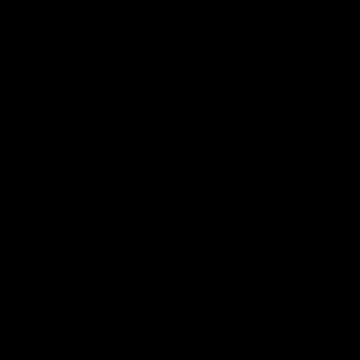
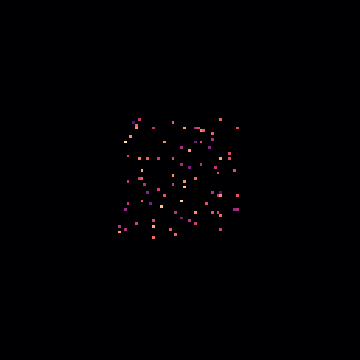
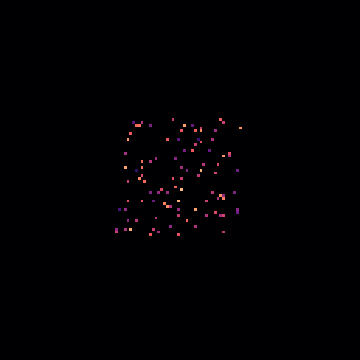
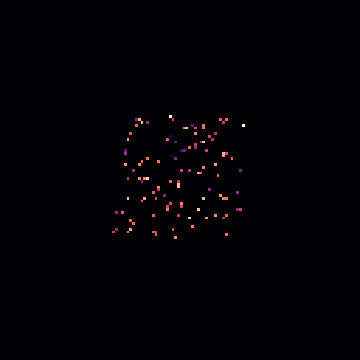
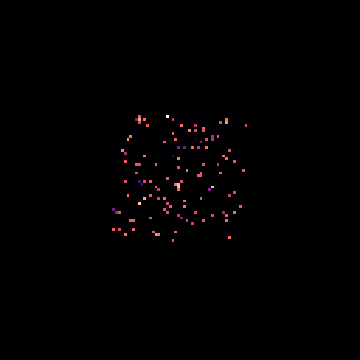
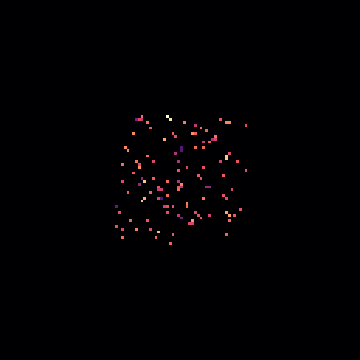
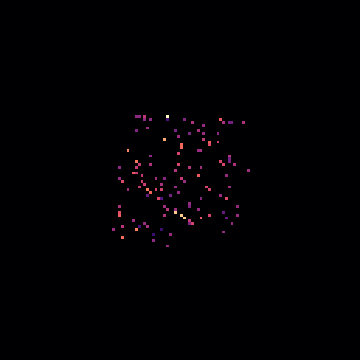
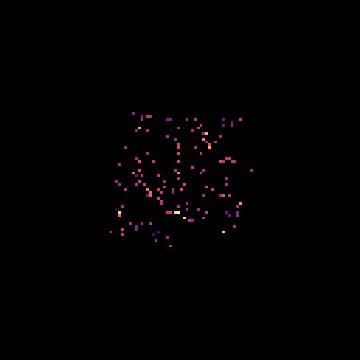
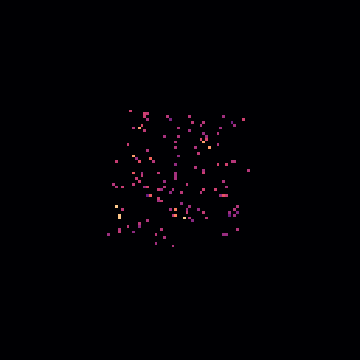
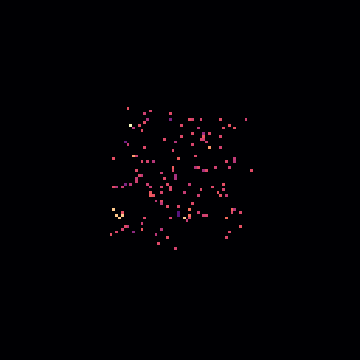
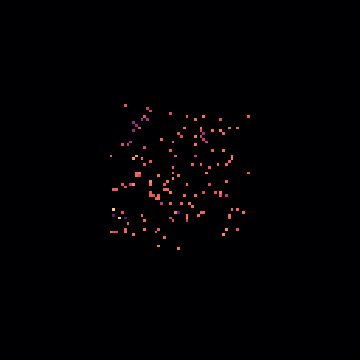
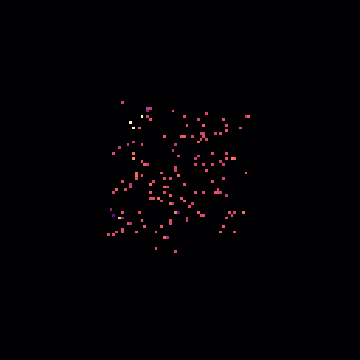
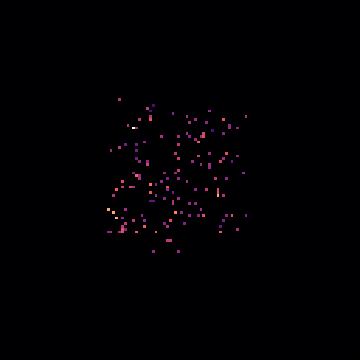
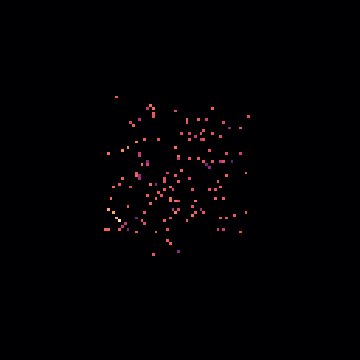
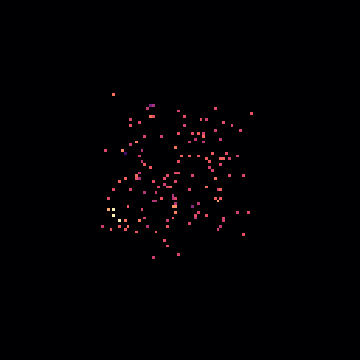
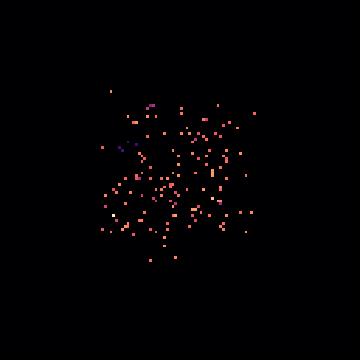
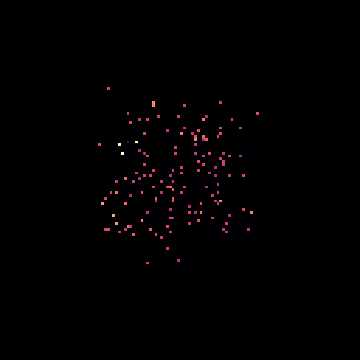
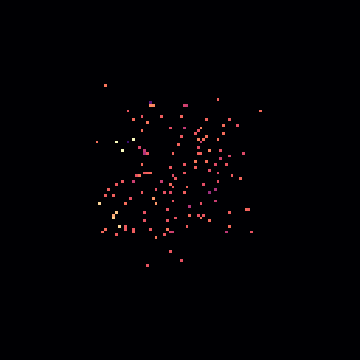
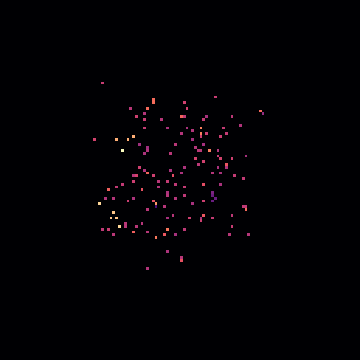
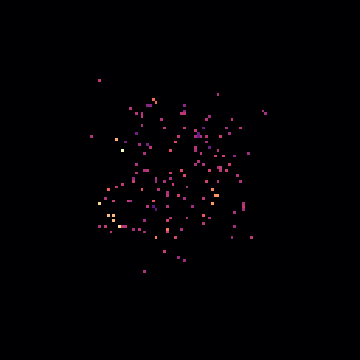
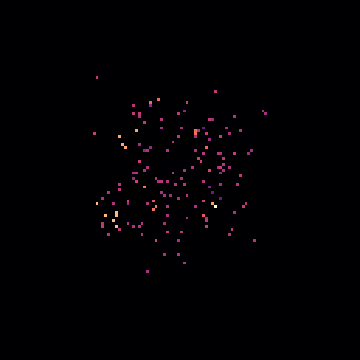
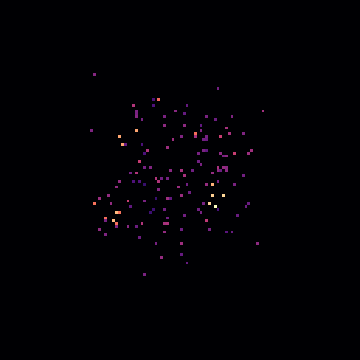
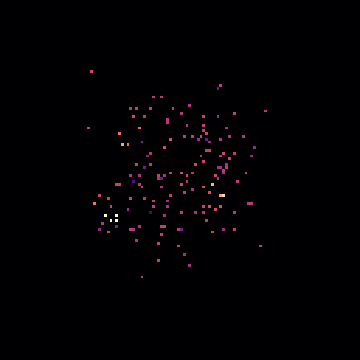
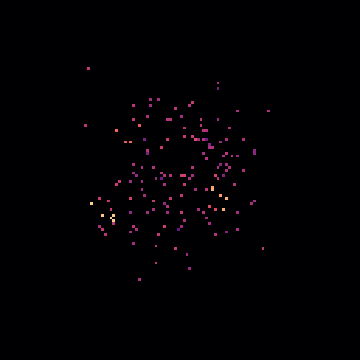
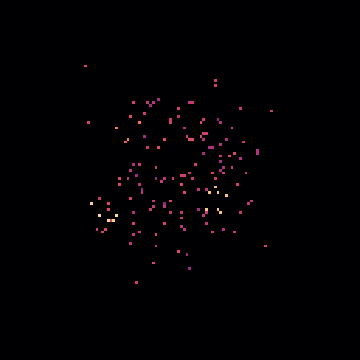
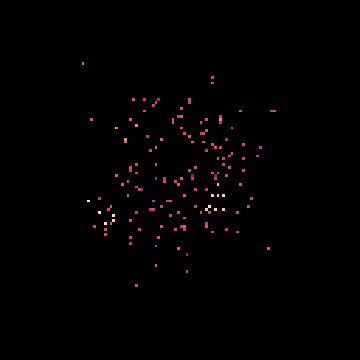
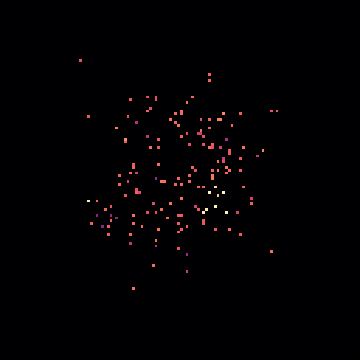
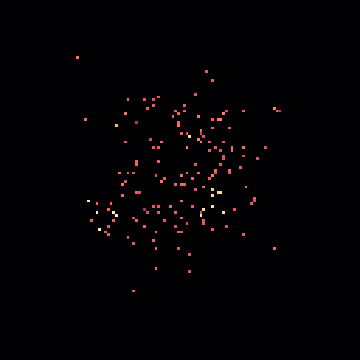
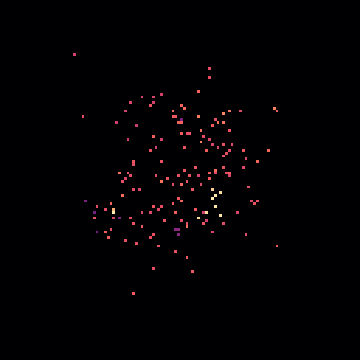
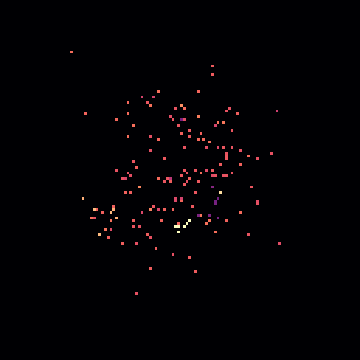
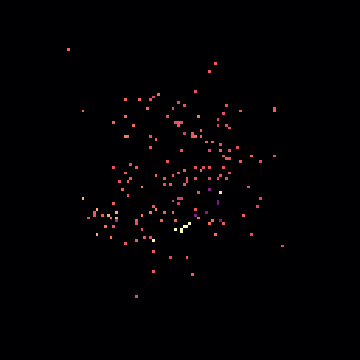
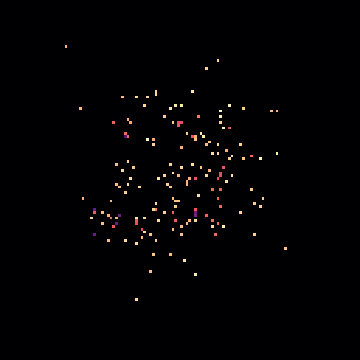
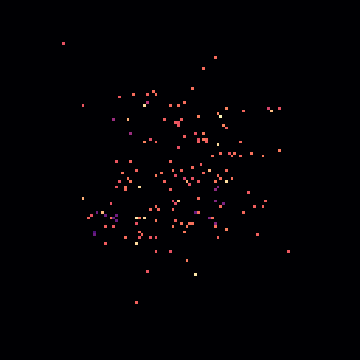
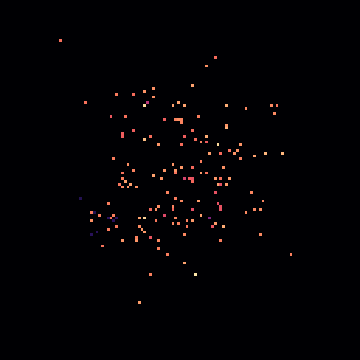
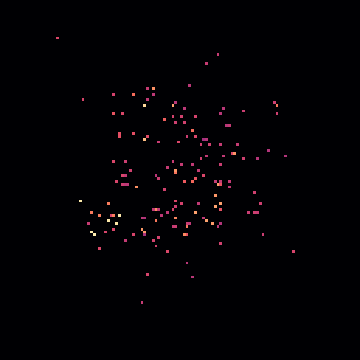
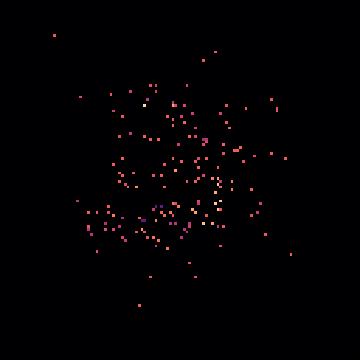
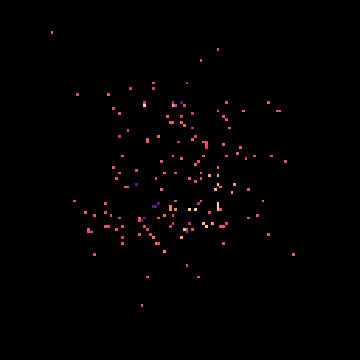
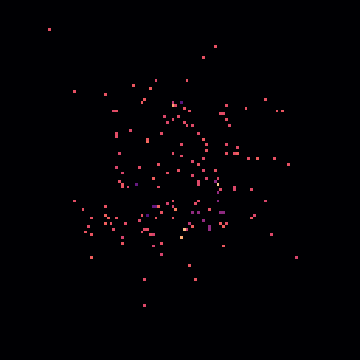
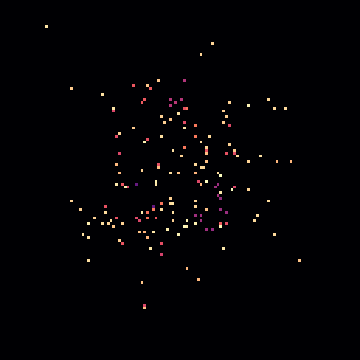
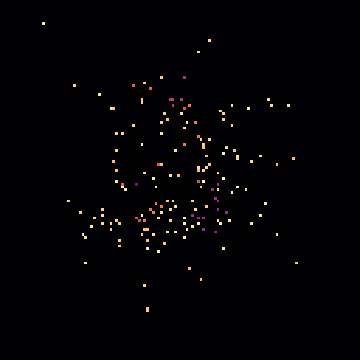
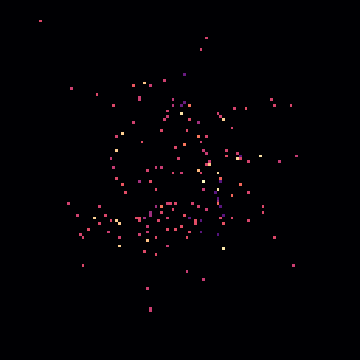
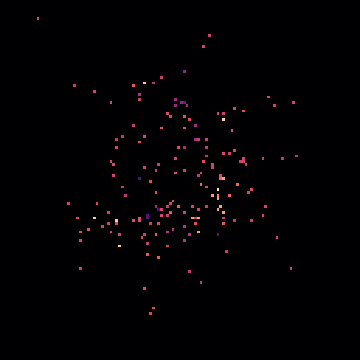
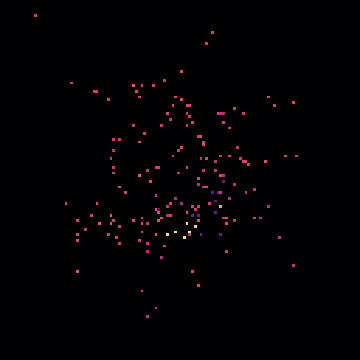
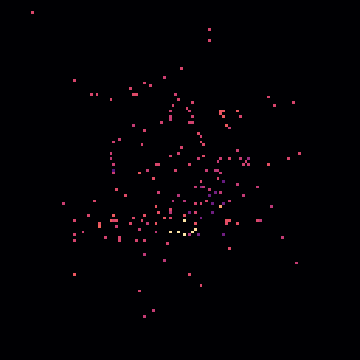
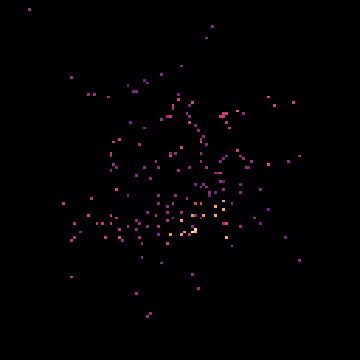
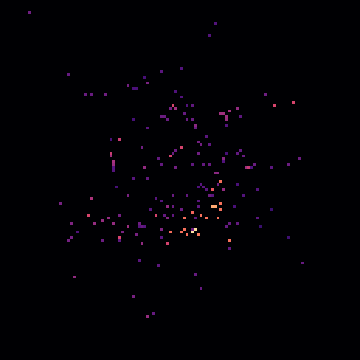
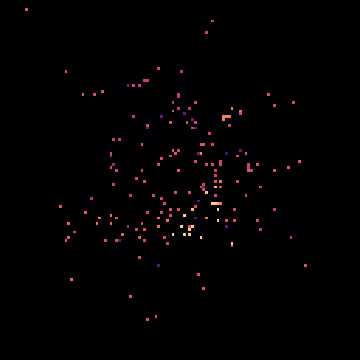
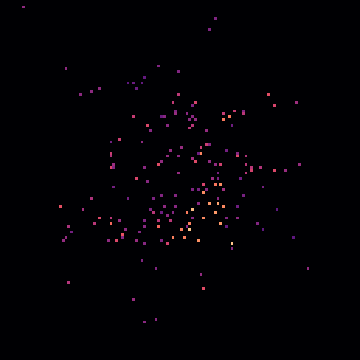
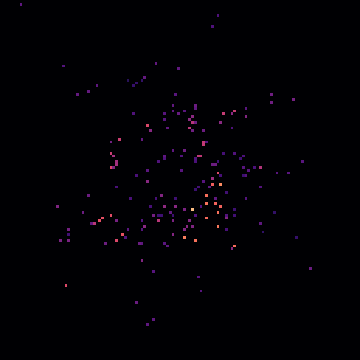
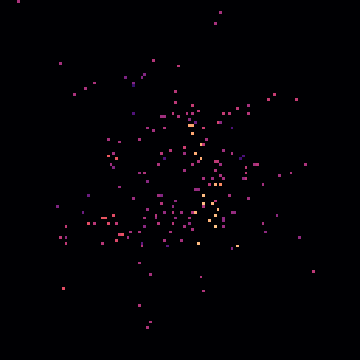
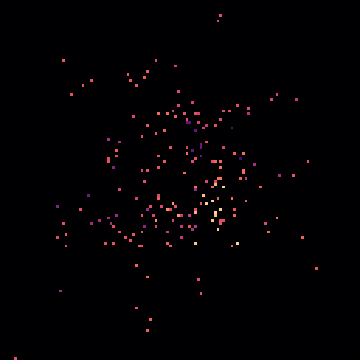
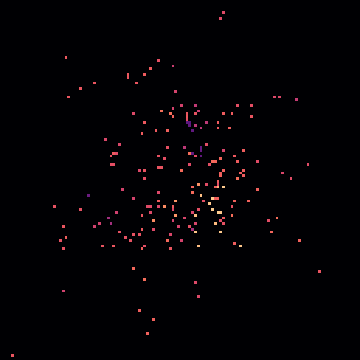
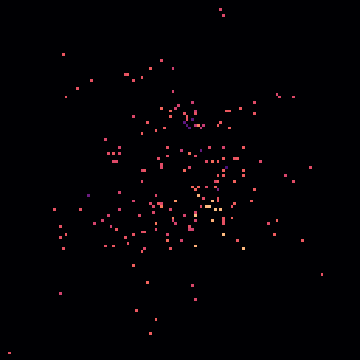
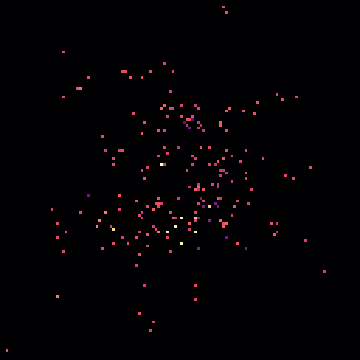
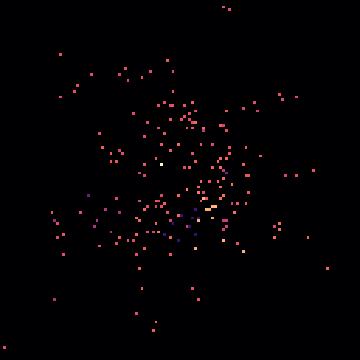
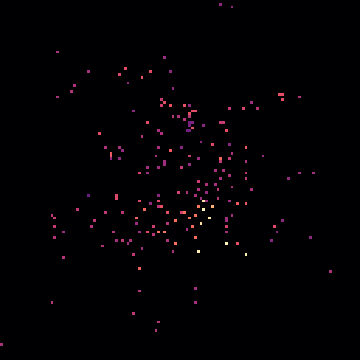
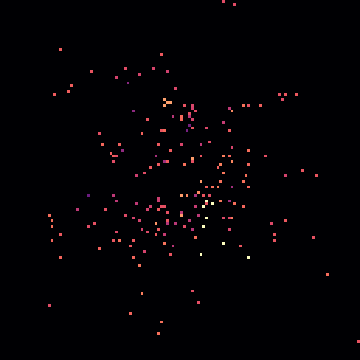
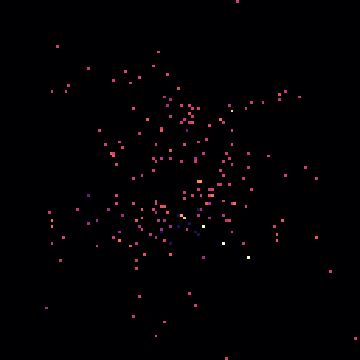
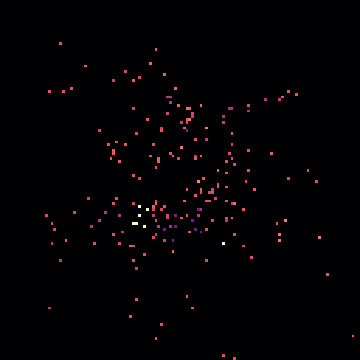
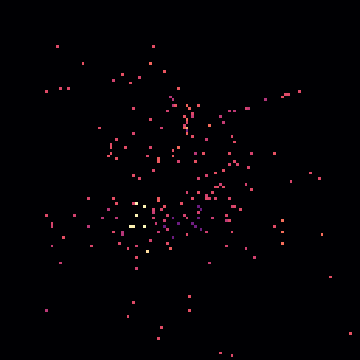
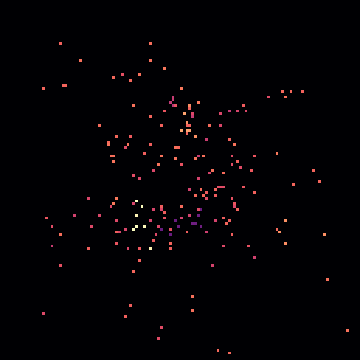
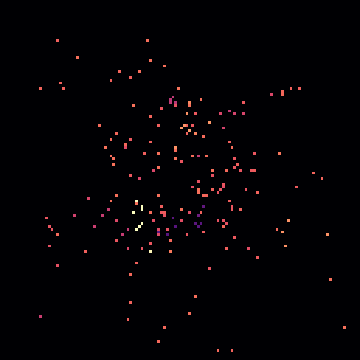
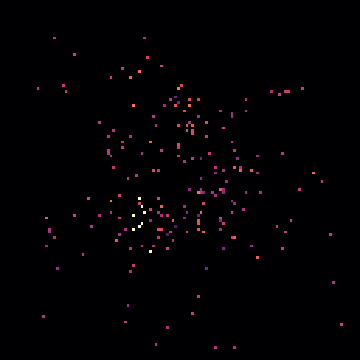
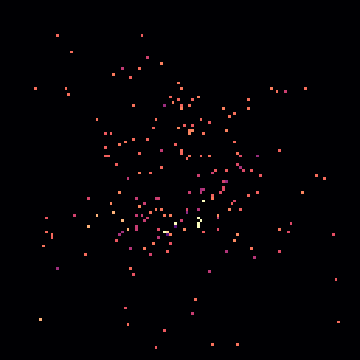
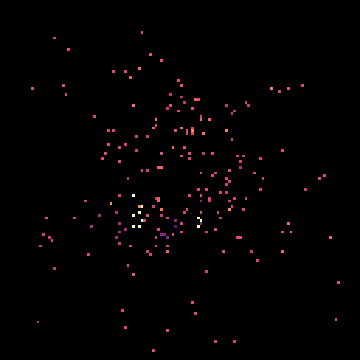
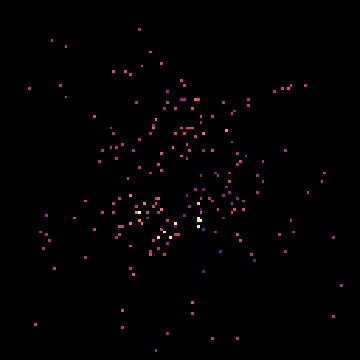
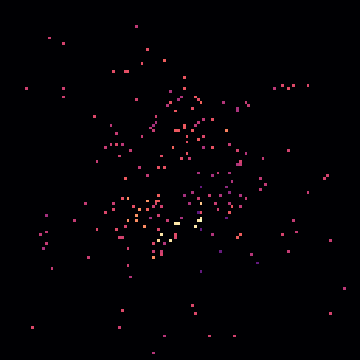
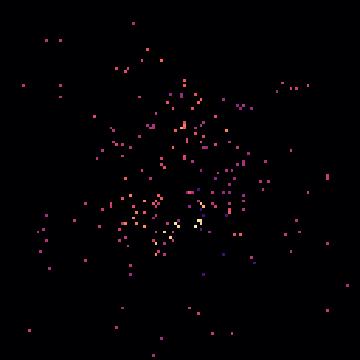
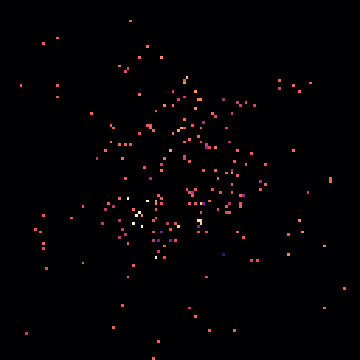
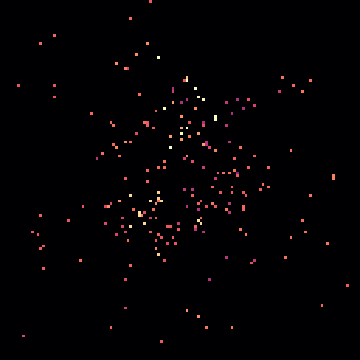
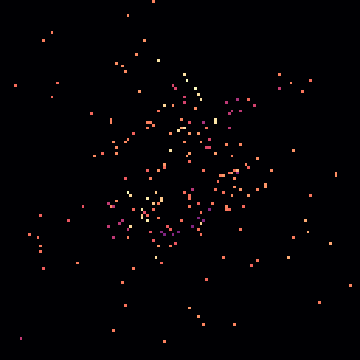
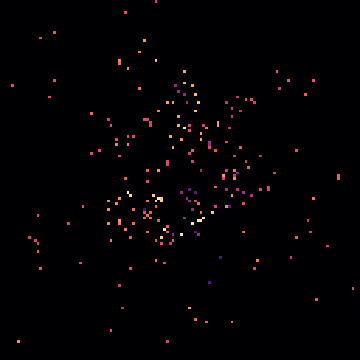
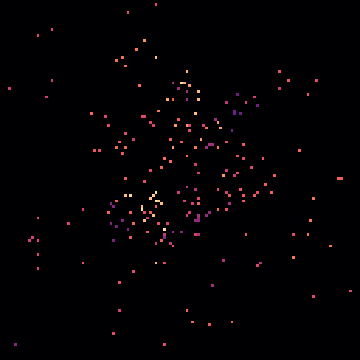
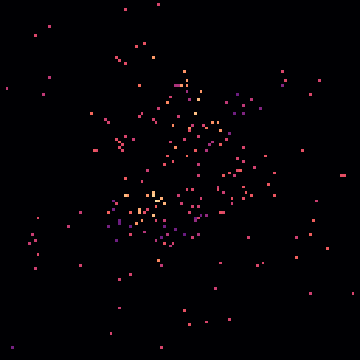
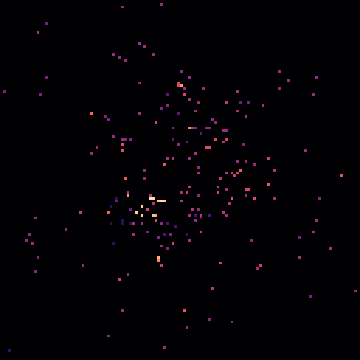
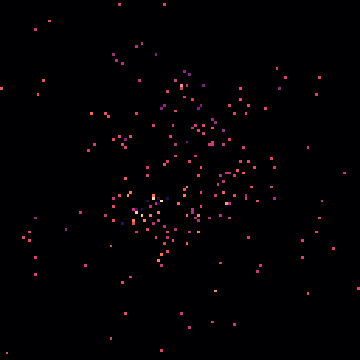
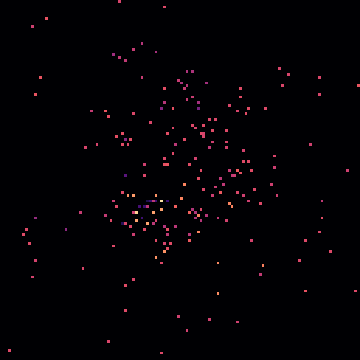
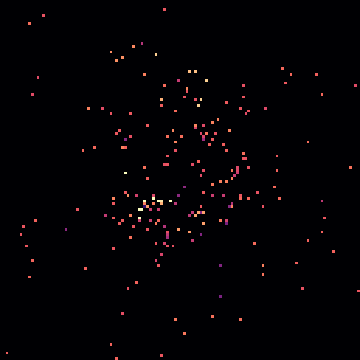
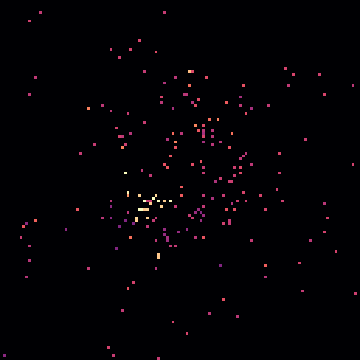
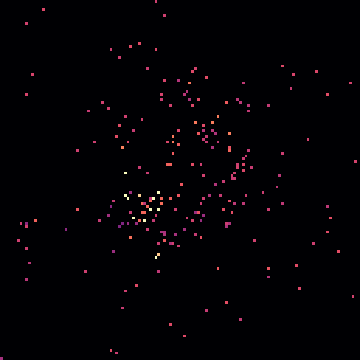
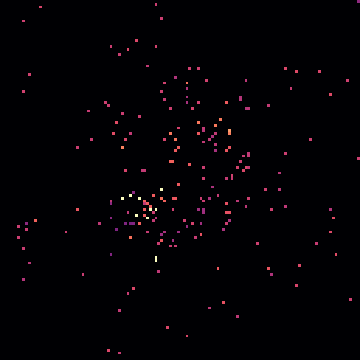
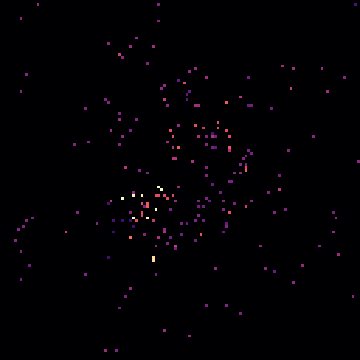
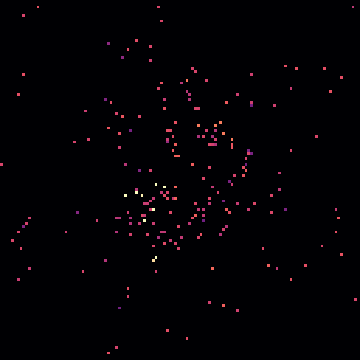
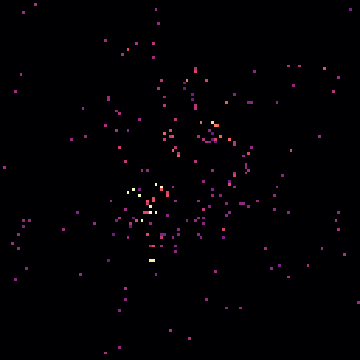
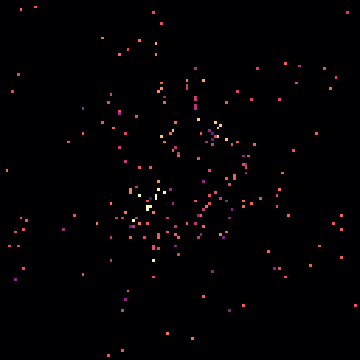
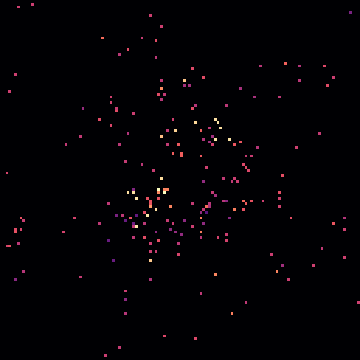
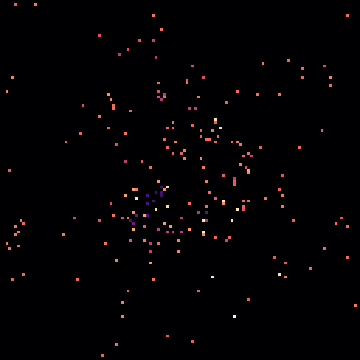
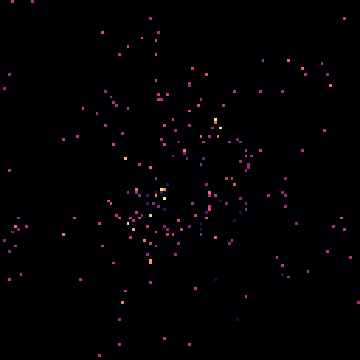
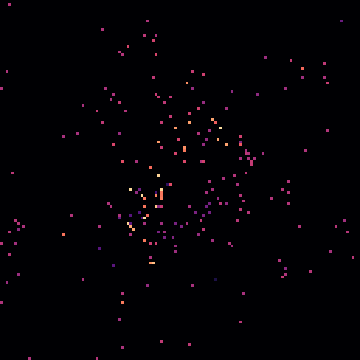
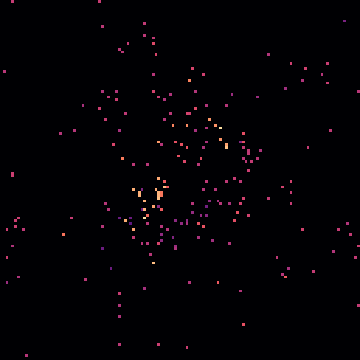
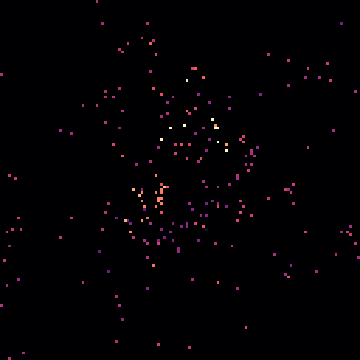
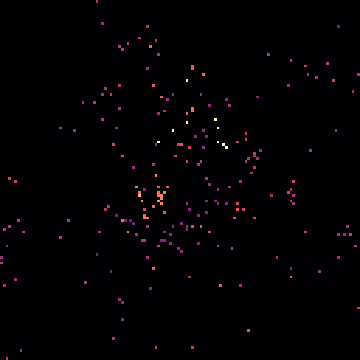
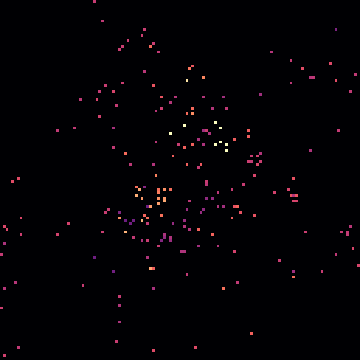
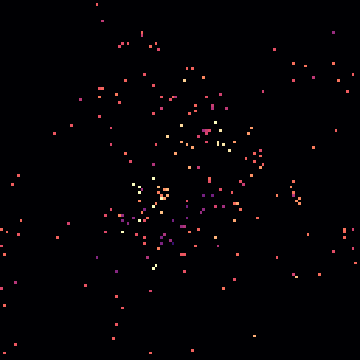
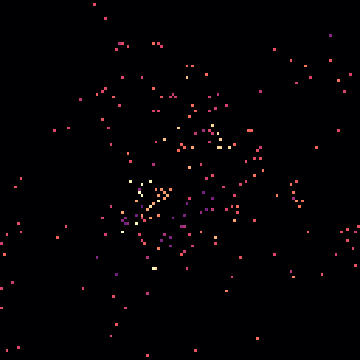
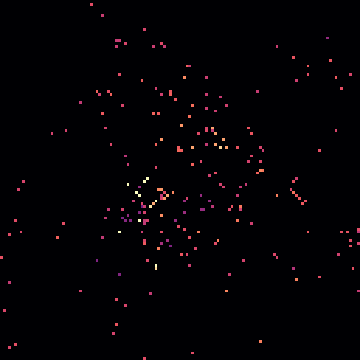
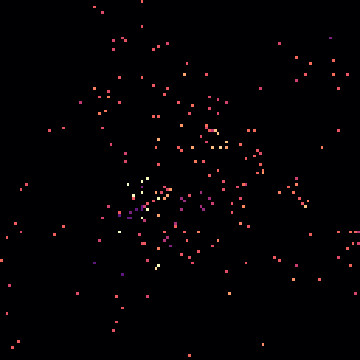
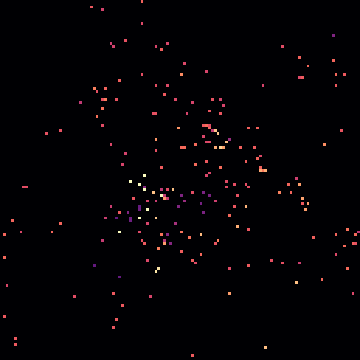
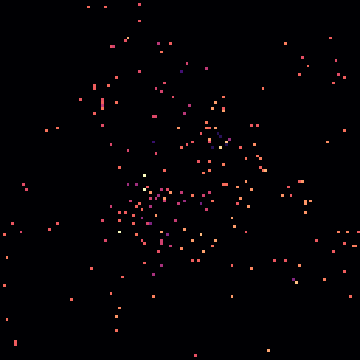
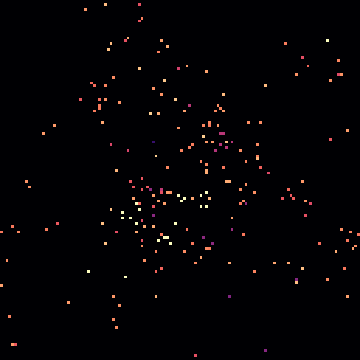

In [9]:
gr

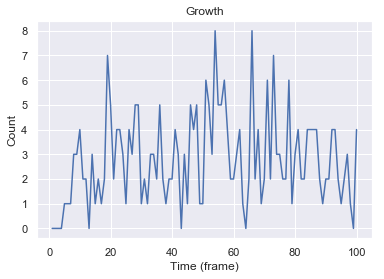

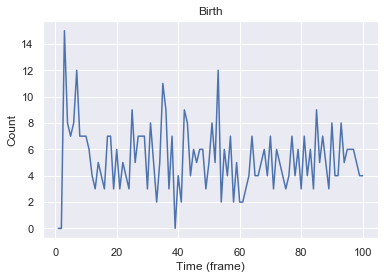

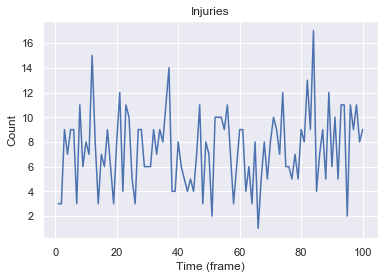

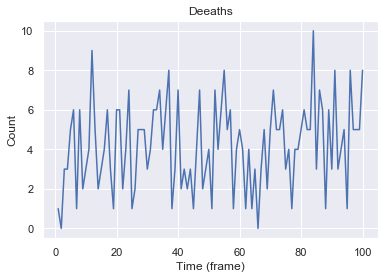

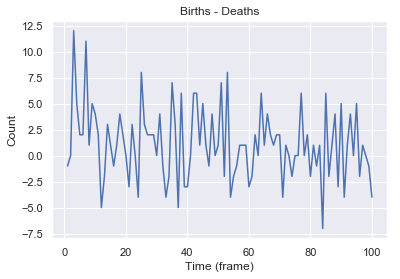

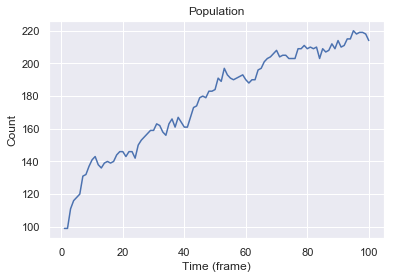

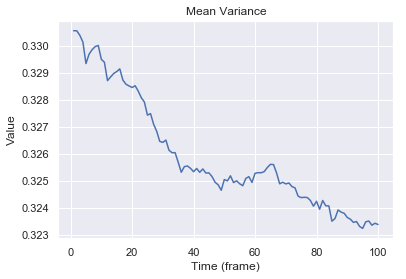

In [10]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [11]:
# Summary
t

array([[  1.        ,   0.        ,   0.        ,   3.        ,
          1.        ,  99.        ,   0.33055685],
       [  2.        ,   0.        ,   0.        ,   3.        ,
          0.        ,  99.        ,   0.33055685],
       [  3.        ,   0.        ,  15.        ,   9.        ,
          3.        , 111.        ,   0.33038845],
       [  4.        ,   0.        ,   8.        ,   7.        ,
          3.        , 116.        ,   0.33013809],
       [  5.        ,   1.        ,   7.        ,   9.        ,
          5.        , 118.        ,   0.32934326],
       [  6.        ,   1.        ,   8.        ,   9.        ,
          6.        , 120.        ,   0.3296872 ],
       [  7.        ,   1.        ,  12.        ,   3.        ,
          1.        , 131.        ,   0.329856  ],
       [  8.        ,   3.        ,   7.        ,  11.        ,
          6.        , 132.        ,   0.32997101],
       [  9.        ,   3.        ,   7.        ,   6.        ,
          2.    

In [12]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 633\nNumber of edges: 533\nAverage degree:   1.6840'

***
# Continue with previous results
***

In [13]:
c, cw, db = extract_tribe(c, cw, 5, [0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 4 0 0 0 0 0 1 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 3 0 1 0 0 0 2 0 0 3 1 0 0 0 2 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 4 0 0
 0 4 0 0 0 0 0 4 0 0 0 2 0 0 0 0 2 0 1 0 0 3 0 4 0 0 2 0 0 0 3 0 0 1 0 0 1
 2 0 0 3 0 0 0 0 2 1 0 0 0 0 4 0 0 0 0 0 0 3 0 0 4 0 0 2 0 0 1 0 0 0 2 3 0
 0 0 0 0 3 0 0 1 0 0 0 0 1 4 0 4 0 0 0 0 0 0 0 4 0 0 1 0 2]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 79, 81, 82, 83, 85, 86, 89, 90, 91, 93, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 128, 130, 131, 133, 135, 136, 138, 139, 140, 142, 143, 145, 146, 149, 150, 152, 153, 154, 155, 158, 159, 160, 161,

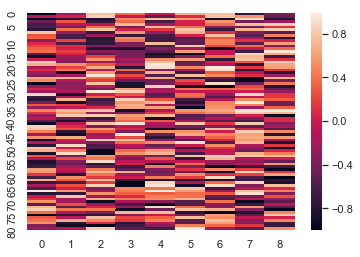

In [14]:
ax = sns.heatmap(cw[0].reshape((sight*sight, 3*3)))

In [15]:
entropy(cw[0])

-inf

In [16]:
gr, c, cw, g, t, a = slime(c[0:100,:], cw[0:100,:], board_size=128, start_pop=100, experimental = True, frames=1000)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.3 seconds.
Frame 20 took 0.2 seconds.
Frame 30 took 0.2 seconds.
Frame 40 took 0.2 seconds.
Frame 50 took 0.2 seconds.
Frame 60 took 0.1 seconds.
Frame 70 took 0.1 seconds.
Frame 80 took 0.2 seconds.
Frame 90 took 0.2 seconds.
Frame 100 took 0.1 seconds.
Frame 110 took 0.1 seconds.
Frame 120 took 0.1 seconds.
Frame 130 took 0.1 seconds.
Frame 140 took 0.1 seconds.
Frame 150 took 0.1 seconds.
Frame 160 took 0.1 seconds.
Frame 170 took 0.1 seconds.
Frame 180 took 0.1 seconds.
Frame 190 took 0.1 seconds.
Frame 200 took 0.1 seconds.
Frame 210 took 0.0 seconds.
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to retu

Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event

Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event

Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event occured!  Had to return
Extinction event

Extinction event occured!  Had to return


IndexError: index 215 is out of bounds for axis 0 with size 215

In [ ]:
gr

In [ ]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [ ]:
# Summary
t

In [ ]:
nx.info(g)

In [ ]:
#import dill
#dill.dump_session('notebook_env.db')

In [ ]:
#import dill
#dill.load_session('notebook_env.db')

In [ ]:
#for i in range(1):
#    output = sig_func(train_in,disc_weights)
#    disc_weights += np.dot(train_in.T,(train_out-output)*output*(1-output))

#test_in = animate.X[coords[0]-lookr:coords[0]+lookr+1,coords[1]-lookr:coords[1]+lookr+1].flatten()
#test_out = sig_func(test_in,disc_weights)
#train_in = np.vstack((train_in,test_in))

#animate.X = life_step(animate.X)
#outcome = animate.X[coords[0]-1:coords[0]+2,coords[1]-1:coords[1]+2].flatten()
#train_out = np.vstack((train_out,outcome))

In [ ]:
int(88 in [3,4,5,2,2]) == 0

In [ ]:
intersection(2,2)

In [ ]:
!pip install Faker